In [2]:
import math
from collections.abc import Iterable
from itertools import pairwise, chain
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import polars as pl
import seaborn as sns
import tqdm.auto as tqdm
from torch import nn
# %env KERAS_BACKEND=torch
#
# import keras
# from keras import layers
# import keras_tuner

# torch.set_float32_matmul_precision("high")

In [3]:
from pathlib import Path
import os

if not Path("./src/kernels").is_dir():
    for parent_path in Path.cwd().parents:
        if (parent_path / "src/kernels").is_dir():
            os.chdir(parent_path)
            break
    else:
        raise FileNotFoundError("Can't find project root")

assert Path("./src/kernels").is_dir()

In [7]:
from src import kernels, convolutions
from src.models import LeNet, POOLING_FUNCTIONS
from src import load_data

In [23]:
import importlib

# from src.kernels import quadratic as quad_kernels
import src.models.simple_lenet
import src.load_data
import src.models.utils
import src.kernels.quadratic
import src.convolutions.cuda_select

importlib.reload(src.kernels.quadratic)
importlib.reload(src.kernels)
importlib.reload(src.kernels.utils)
importlib.reload(src.convolutions.cuda_select)
importlib.reload(src.convolutions.unfold_broadcast)
importlib.reload(src.models.utils)
importlib.reload(src.models.simple_lenet)
importlib.reload(src.models)
importlib.reload(src.load_data)
from src.models import LeNet, POOLING_FUNCTIONS
from src import load_data

# kernels = importlib.reload(kernels)
# convolutions = importlib.reload(convolutions)

In [24]:
k_mnist = load_data.k_mnist()
k_mnist

Dataset(x_train=torch.Size([60000, 1, 28, 28]), x_test=torch.Size([10000, 1, 28, 28]), y_train=torch.Size([60000]), y_test=torch.Size([10000]))

In [228]:
# from collections import defaultdict
#
#
# class InspectScales(keras.callbacks.Callback):
#     store_targets = {
#         kernels.QuadraticKernelIso2D: ("log_stds",),
#         kernels.utils.LearnedSpectral2D: ("log_stds", "thetas"),
#     }
#
#     def __init__(self, store: dict[str, list[np.ndarray] | np.ndarray], per_batch: bool = False):
#         super().__init__()
#         self.mod_counter = 0
#         self.store = store
#         self.per_batch = per_batch
#
#     def on_epoch_end(self, epoch, logs=None):
#         if not self.per_batch:
#             self.mod_counter = 0
#             self.recurse_mod(self.model.layers[0].module)
#
#     def on_train_batch_end(self, batch, logs=None):
#         if self.per_batch:
#             self.mod_counter = 0
#             self.recurse_mod(self.model.layers[0].module)
#
#     def recurse_mod(self, mod: torch.nn.Module):
#         for child in mod.children():
#             cls = type(child)
#             if cls not in self.store_targets:
#                 self.recurse_mod(child)
#                 continue
#
#             num, self.mod_counter = self.mod_counter, self.mod_counter + 1
#             targets = self.store_targets[cls]
#             for target in targets:
#                 val = getattr(child, target).squeeze().numpy(force=True)
#                 self.store.setdefault(f"{num}.{target}", []).append(val)
#
#     def on_train_end(self, logs=None):
#         for name, vals in self.store.items():
#             self.store[name] = np.stack(vals)

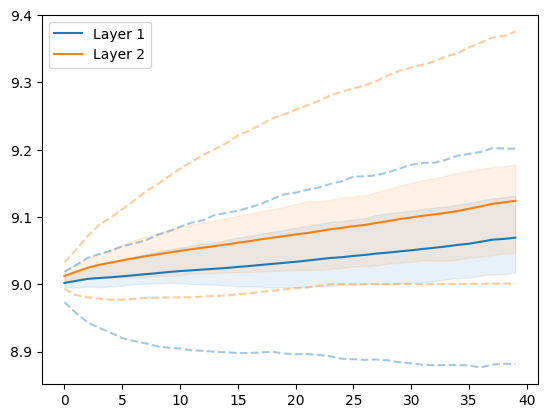

In [265]:
def plot_ci(vals: np.ndarray, ax: plt.Axes = None, label: str = ""):
    assert len(vals.shape) == 2, "Cannot plot multiple val types"
    if ax is None:
        _, ax = plt.subplots()

    q0, q1, q3, q4 = np.quantile(vals, [0, 0.25, 0.75, 1], axis=1)
    colour = ax.plot(vals.mean(axis=1), label=label)[0].get_color()
    ax.plot(q0, color=colour, linestyle="dashed", alpha=0.4)
    ax.plot(q4, color=colour, linestyle="dashed", alpha=0.4)
    ax.fill_between(range(len(vals)), q1, q3, color=colour, alpha=0.1)


_, test_ax = plt.subplots()
plot_ci(scales["0.log_stds"][..., 0], ax=test_ax, label="Layer 1")
# plot_ci(scales['0.thetas'], ax=test_ax, label="Layer 1")
plot_ci(scales["1.log_stds"][..., 0], ax=test_ax, label="Layer 2")
# plot_ci(scales['1.thetas'], ax=test_ax, label="Layer 2")
plt.legend()

In [241]:
d[0].get_color()

'#1f77b4'

In [9]:
kernels.QuadraticKernelIso2D(1, 1, 5, init=3.7)()

tensor([[[[-0.5405, -0.3378, -0.2703, -0.3378, -0.5405],
          [-0.3378, -0.1351, -0.0676, -0.1351, -0.3378],
          [-0.2703, -0.0676, -0.0000, -0.0676, -0.2703],
          [-0.3378, -0.1351, -0.0676, -0.1351, -0.3378],
          [-0.5405, -0.3378, -0.2703, -0.3378, -0.5405]]]],
       grad_fn=<ViewBackward0>)

In [11]:
# importlib.reload(src.kernels.utils)
# importlib.reload(src.kernels.quadratic)
# importlib.reload(src.kernels)
k2 = kernels.QuadraticKernelSpectral2D(1, 1, 5, init=3.7)
k3 = kernels.QuadraticKernelCholesky2D(1, 1, 5, init=3.7)
k2()

tensor([[[[-0.5405, -0.3378, -0.2703, -0.3378, -0.5405],
          [-0.3378, -0.1351, -0.0676, -0.1351, -0.3378],
          [-0.2703, -0.0676, -0.0000, -0.0676, -0.2703],
          [-0.3378, -0.1351, -0.0676, -0.1351, -0.3378],
          [-0.5405, -0.3378, -0.2703, -0.3378, -0.5405]]]],
       grad_fn=<MulBackward0>)

In [186]:
k2.covs.cov()

tensor([[[[3.0000, 0.0000],
          [0.0000, 3.0000]]]], grad_fn=<LinalgInvExBackward0>)

In [13]:
if "res" not in globals():
    res = {}
res = res

In [139]:
importlib.reload(src.models.trainer)
importlib.reload(src.models.simple_lenet)
importlib.reload(src.models)
importlib.reload(src.load_data)
importlib.reload(src.kernels.quadratic)
importlib.reload(src.kernels)
from src.models import LeNet, POOLING_FUNCTIONS
from src import load_data

# pool_fn = 'iso-5'
for pool_fn in tqdm.tqdm(POOLING_FUNCTIONS, desc="Pooling types", unit="trial"):
    res[pool_fn] = LeNet.fit_many(k_mnist, pool_fn=pool_fn, init="uniform", batch_size=1024, epochs=50)

Pooling types:   0%|          | 0/10 [00:00<?, ?trial/s]

standard-2:uniform:   0%|          | 0/20 [00:00<?, ?run/s]

standard-3:uniform:   0%|          | 0/20 [00:00<?, ?run/s]

standard-5:uniform:   0%|          | 0/20 [00:00<?, ?run/s]

standard-7:uniform:   0%|          | 0/20 [00:00<?, ?run/s]

iso-3:uniform:   0%|          | 0/20 [00:00<?, ?run/s]

iso-5:uniform:   0%|          | 0/20 [00:00<?, ?run/s]

iso-7:uniform:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-3:uniform:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-5:uniform:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-7:uniform:   0%|          | 0/20 [00:00<?, ?run/s]

In [229]:
for size in tqdm.tqdm((3, 5, 7), desc="Aniso sizes", unit="trial"):
    res[f"aniso-{size}-spin"] = LeNet.fit_many(k_mnist, pool_fn=f"aniso-{size}", init="spin")
    res[f"aniso-{size}-uiso"] = LeNet.fit_many(k_mnist, pool_fn=f"aniso-{size}", init="uniform-iso")

Aniso sizes:   0%|          | 0/3 [00:00<?, ?trial/s]

aniso-3:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-3:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-5:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-5:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-7:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-7:   0%|          | 0/20 [00:00<?, ?run/s]

dict_keys(['iso-5', 'lr=0.001', 'lr=0.0016681005372000592', 'lr=0.0027825594022071257', 'lr=0.004641588833612777', 'lr=0.007742636826811269', 'lr=0.01291549665014884', 'lr=0.021544346900318832', 'lr=0.03593813663804626', 'lr=0.05994842503189409', 'lr=0.1', 'standard-2', 'standard-3', 'standard-5', 'standard-7', 'iso-3', 'iso-7', 'aniso-3', 'aniso-5', 'aniso-7'])

In [142]:
res_sort = {k: res[k] for k in sorted(res) if 'lr=' not in k}
pl.DataFrame(res_sort).write_parquet("data/res_100ep.pq")

In [144]:
res_sort

{'aniso-3': shape: (20, 4)
 ┌────────┬──────────┬──────────┬──────────┐
 │ acc    ┆ min_f1   ┆ max_f1   ┆ macro_f1 │
 │ ---    ┆ ---      ┆ ---      ┆ ---      │
 │ f64    ┆ f64      ┆ f64      ┆ f64      │
 ╞════════╪══════════╪══════════╪══════════╡
 │ 0.9555 ┆ 0.92128  ┆ 0.970297 ┆ 0.955436 │
 │ 0.9566 ┆ 0.922686 ┆ 0.969546 ┆ 0.956549 │
 │ 0.9564 ┆ 0.924319 ┆ 0.969576 ┆ 0.956358 │
 │ 0.9569 ┆ 0.924395 ┆ 0.975634 ┆ 0.956841 │
 │ 0.9601 ┆ 0.931853 ┆ 0.976143 ┆ 0.960066 │
 │ …      ┆ …        ┆ …        ┆ …        │
 │ 0.9573 ┆ 0.918429 ┆ 0.97265  ┆ 0.95725  │
 │ 0.9592 ┆ 0.932653 ┆ 0.972678 ┆ 0.959158 │
 │ 0.9527 ┆ 0.923935 ┆ 0.966315 ┆ 0.952673 │
 │ 0.9585 ┆ 0.925115 ┆ 0.973619 ┆ 0.958414 │
 │ 0.9577 ┆ 0.92331  ┆ 0.971717 ┆ 0.95767  │
 └────────┴──────────┴──────────┴──────────┘,
 'aniso-5': shape: (20, 4)
 ┌────────┬──────────┬──────────┬──────────┐
 │ acc    ┆ min_f1   ┆ max_f1   ┆ macro_f1 │
 │ ---    ┆ ---      ┆ ---      ┆ ---      │
 │ f64    ┆ f64      ┆ f64      ┆ f64      │


In [ ]:
def ren(n: str) -> str:
    if n.count("-") == 1:
        return n + "-uni"
    return n


pl.scan_parquet("data/res1.pq").rename(ren).sink_parquet("data/res2.pq")

(0.94, 0.965)

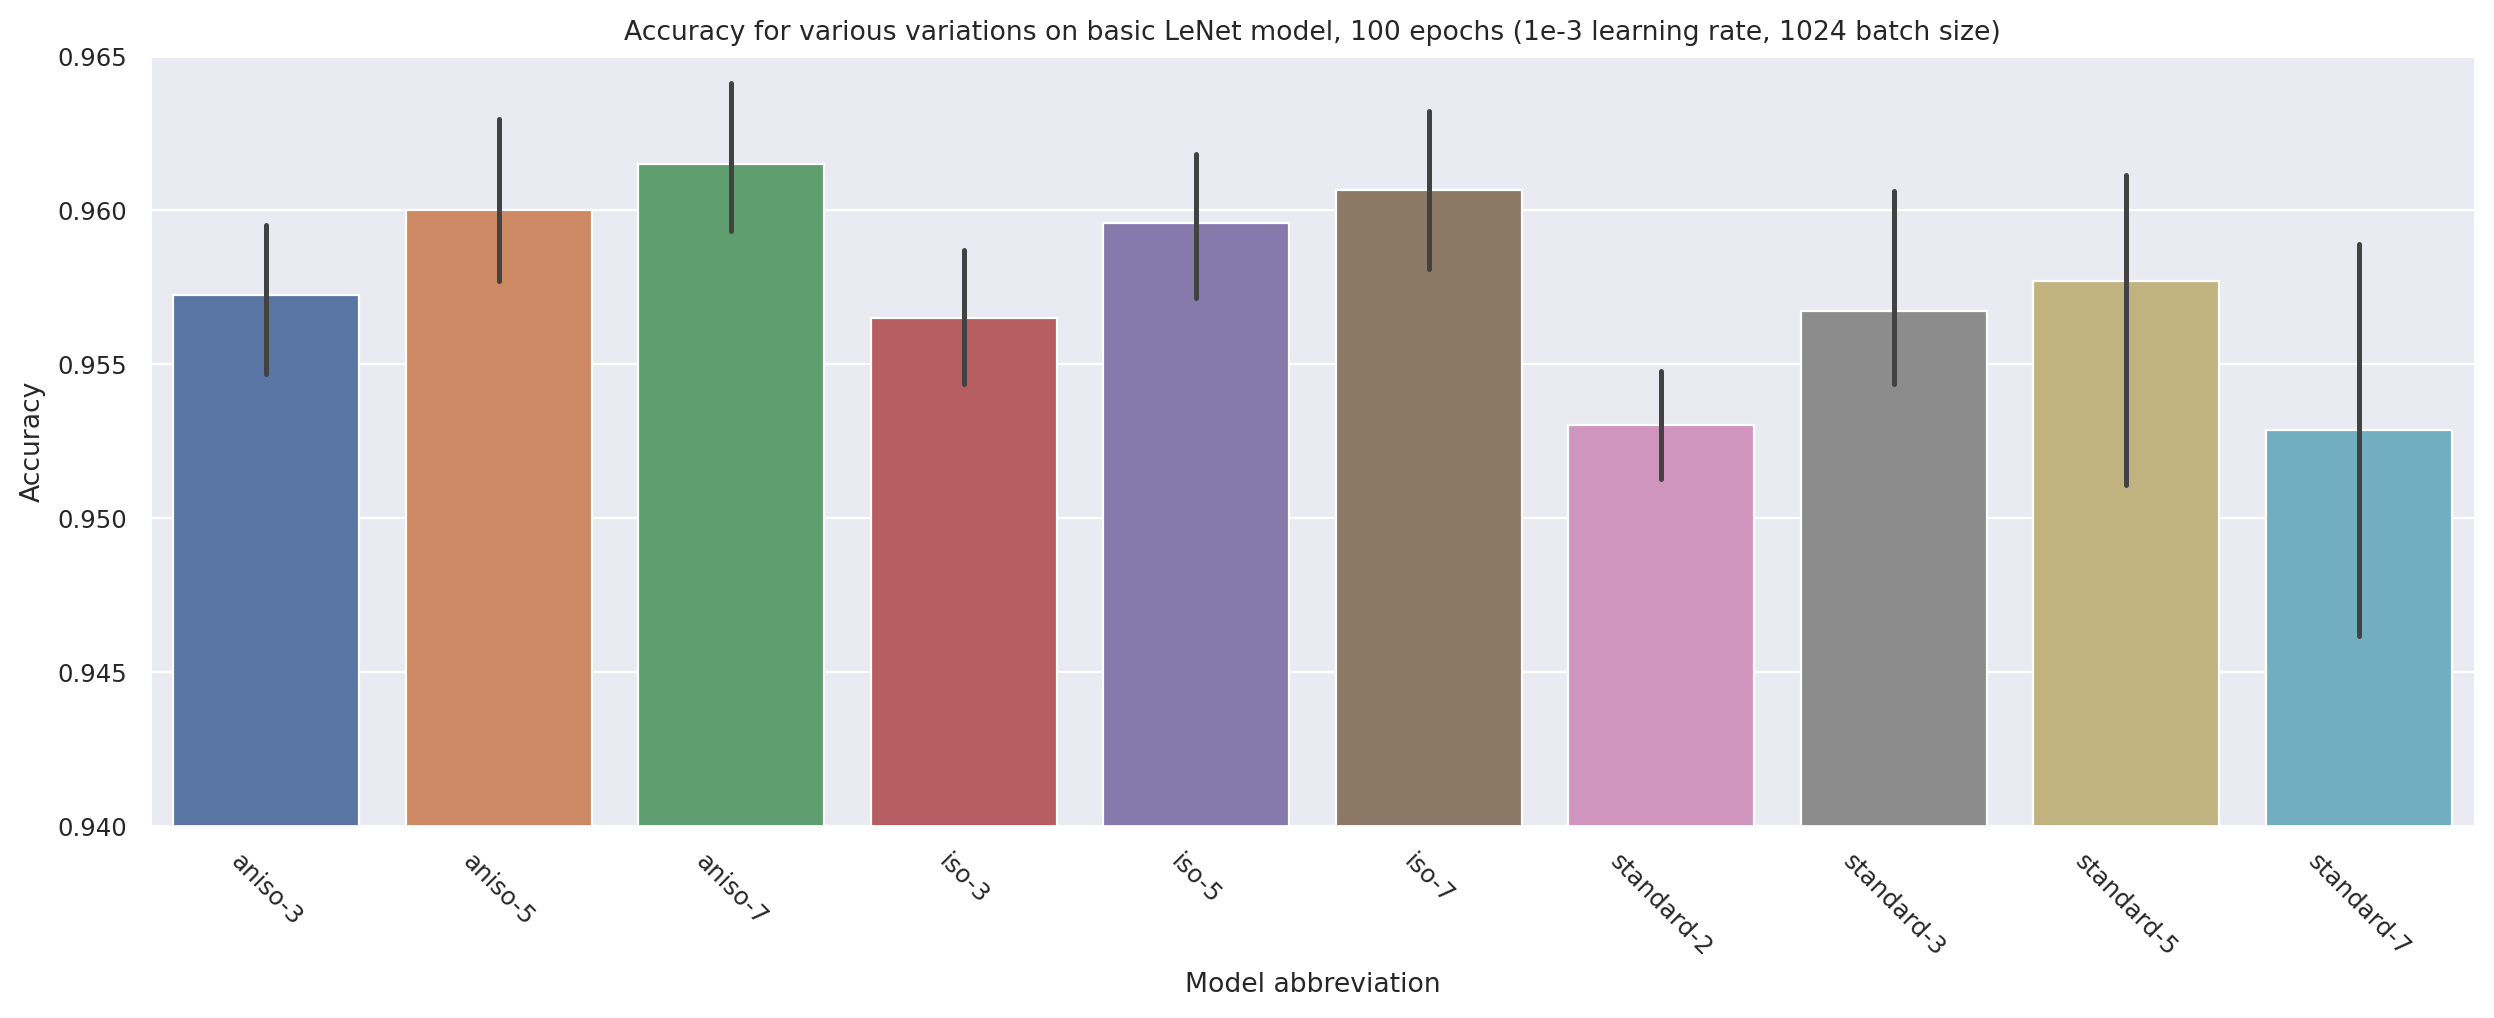

In [147]:
df = pl.scan_parquet("data/res_100ep.pq").select(pl.all().struct.field("acc").name.keep()).collect()
# sns.barplot({'a':[0.9471, 0.9617, 0.9567, 0.9646, 0.9506, 0.9596, 0.9531, 0.9553, 0.9578, 0.9642, 0.9532, 0.9458, 0.9513, 0.953, 0.9582, 0.9526, 0.9578, 0.9631, 0.96, 0.9557]}, errorbar=("pi", 90))
plt.figure(figsize=(15, 5), dpi=200)
sns.set_theme("paper", "darkgrid")
sns.barplot(df.to_pandas(), errorbar=("pi", 90)).set(ylabel="Accuracy", xlabel="Model abbreviation",
                                                     title="Accuracy for various variations on basic LeNet model, 100 epochs (1e-3 learning rate, 1024 batch size)")
plt.xticks(rotation=-45)
plt.ylim(0.940, 0.965)

In [ ]:
hs = {}

In [93]:
importlib.reload(src.load_data)
from src import load_data

k_mnist = load_data.k_mnist()
km_tune = k_mnist.tuning_split()
print(k_mnist.y_train.dtype)

torch.int64


In [ ]:
import importlib

importlib.reload(src.models.utils)
importlib.reload(src.models.trainer)
importlib.reload(src.models.simple_lenet)
importlib.reload(src.models)
importlib.reload(src.load_data)
importlib.reload(src.kernels.quadratic)
importlib.reload(src.kernels)
from src.models import LeNet, POOLING_FUNCTIONS
from src import load_data
from src.models.utils import history_callback

hist = history_callback(km_tune)
for lr in tqdm.tqdm(np.logspace(-3, -1, num=10), unit="trial"):
    lr = lr.item()
    res[f'{lr=}'] = LeNet.fit_many(km_tune, pool_fn="iso-5", init="uniform", count=7, epoch_callback=hist, lr=lr,
                                   batch_size=1024, epochs=100)
    hs[lr] = hist.result()

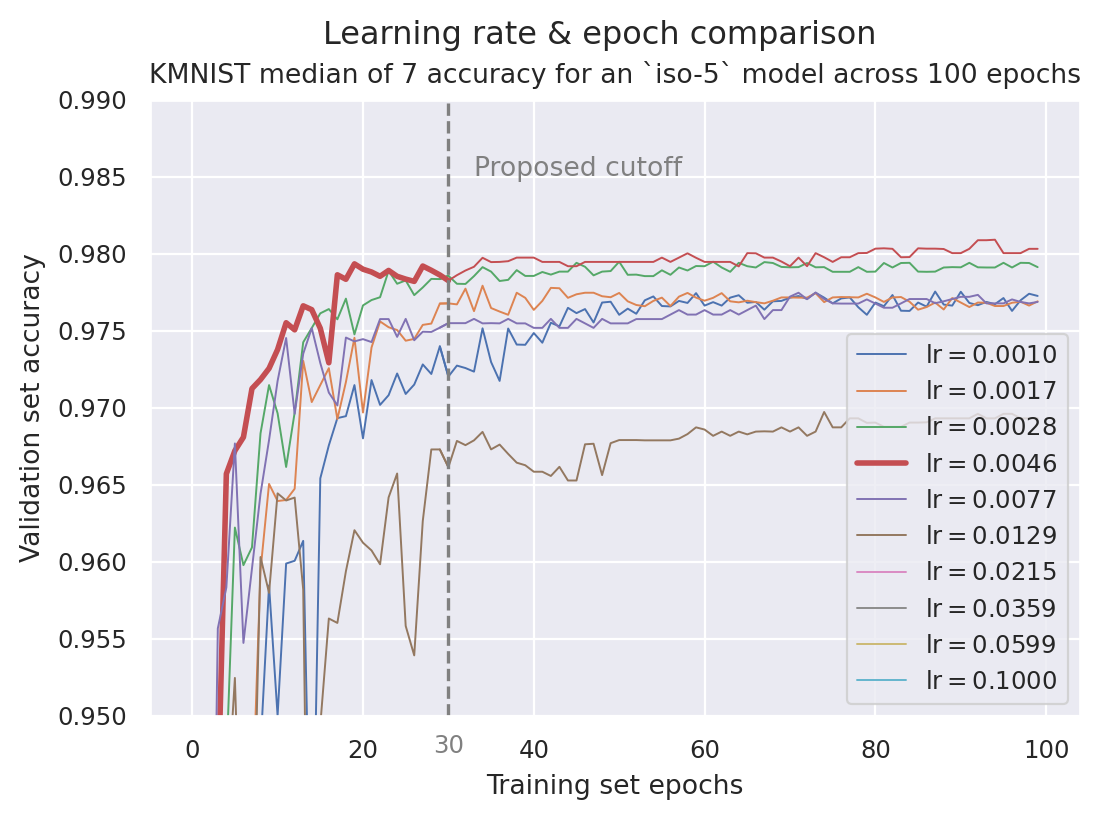

In [230]:
sns.set_theme("paper", "darkgrid")
plt.figure(dpi=200, figsize=(6, 4))
for i, (lr, (vls, trns)) in enumerate(hs.items()):
    vals = np.median(vls["min_f1"].to_numpy().reshape(-1, 7, 100)[i], axis=0)
    color = plt.plot(range(31), vals[:31], label=f"lr$= {lr:.4f}$", linewidth=0.7 if round(lr, 4) != 0.0046 else 2)[
        0].get_color()
    plt.plot(range(29, 100), vals[29:], color=color, linewidth=0.7)
plt.ylim(0.95, 0.99)
plt.suptitle("Learning rate & epoch comparison")
plt.title("KMNIST median of 7 accuracy for an `iso-5` model across 100 epochs")
plt.xlabel("Training set epochs")
plt.ylabel("Validation set accuracy")
plt.axvline(30, linestyle='dashed', color='gray')
plt.text(33, 0.98505, "Proposed cutoff", color='gray')
plt.xticks([30], ["30"], minor=True)
plt.tick_params("x", colors="gray", which="minor")
plt.legend()